In [1]:
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandas_datareader as pdr
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
import numpy as np
import fix_yahoo_finance
import scipy as sp
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import probplot
from scipy import stats
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



종목명을 종목코드로 바꿔서 가져올 수 있게 해주는 함수 정의

In [2]:
stock_type = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt'
}
def get_code(df, name):
  code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
  code = code.strip()
  return code


def get_download_stock(market_type=None):
  market_type_param = stock_type[market_type]
  download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
  download_link = download_link + '?method=download'
  download_link = download_link + '&marketType=' + market_type_param

  df = pd.read_html(download_link, header=0)[0]
  return df;


def get_download_kospi():
  df = get_download_stock('kospi')
  df.종목코드 = df.종목코드.map('{:06d}.KS'.format)
  return df


def get_download_kosdaq():
  df = get_download_stock('kosdaq')
  df.종목코드 = df.종목코드.map('{:06d}.KQ'.format)
  return df

In [3]:

kospi_df = get_download_kospi()
kosdaq_df = get_download_kosdaq()


code_df = pd.concat([kospi_df, kosdaq_df])


code_df = code_df[['회사명', '종목코드']]

code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

code_df

,name,code
0,JS전선,005560.KS
1,거북선2호,101380.KS
2,거북선6호,114140.KS
3,교보메리츠,064900.KS
4,국제관광공사,028780.KS
...,...,...
2296,해성산업,034810.KQ
2297,해성옵틱스,076610.KQ
2298,행남사,008800.KQ
2299,홈센타홀딩스,060560.KQ


차트데이터를 가져올 기간과 페어 주식 입력

In [4]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 12, 31)
stock1 = get_code(code_df, '삼성SDI')
stock2 = get_code(code_df, 'LG화학')

In [5]:
chart_data1 = pdr.DataReader(stock1, "yahoo", start, end)
chart_data2 = pdr.DataReader(stock2, "yahoo", start, end)

수정종가 데이터만 추출하기

In [6]:
chart_data_1 = chart_data1.iloc[:,[5]]
chart_data_2 = chart_data2.iloc[:,[5]]

페어 주식 컬럼명을 A,B로 변경

In [7]:
chart = pd.concat([chart_data_1,chart_data_2],axis=1)
chart.columns = ['A','B']

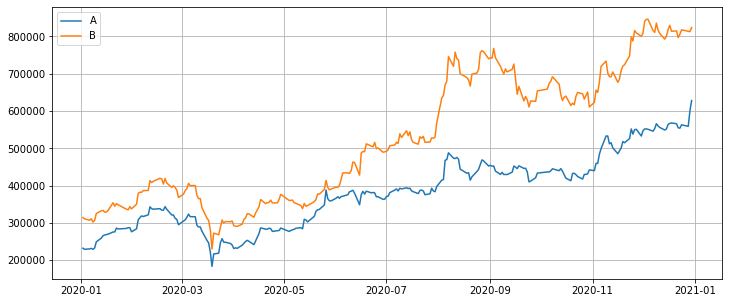

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
ax.grid(True)
plt.plot(chart)
plt.legend(['A', 'B'])

A, B 수정종가를 상대주가로 변환

In [9]:
p1 = (chart['A']-chart.mean(axis=0)['A'])/chart.std(axis=0)['A']
p2 = (chart['B']-chart.mean(axis=0)['B'])/chart.std(axis=0)['B']

상대주가를 데이터프레임으로 만들기

In [10]:
p11 = pd.DataFrame(p1)
p22 = pd.DataFrame(p2)
result = pd.concat([p11,p22],axis=1)
result.columns = ['Ar','Br']

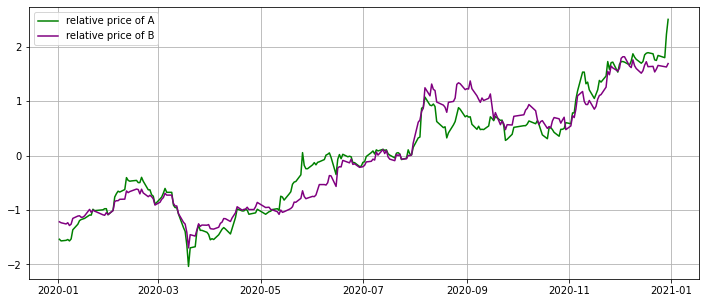

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
ax.grid(True)
plt.plot(p1,color = 'green', label='relative price of A')
plt.plot(p2,color = 'purple', label='relative price of B')
plt.legend()

스프레드 정의, 2*시그마 정의

In [12]:
r = p1-p2
P = 2*r.std()

In [13]:
result['spread'] = result['Ar']-result['Br']
result

,Ar,Br,spread
Date,,,
2020-01-02,-1.536354,-1.216101,-0.320254
2020-01-03,-1.566950,-1.233196,-0.333753
2020-01-06,-1.556751,-1.255991,-0.300760
2020-01-07,-1.541453,-1.233196,-0.308257
2020-01-08,-1.566950,-1.284484,-0.282466
...,...,...,...
2020-12-23,1.747562,1.587613,0.159949
2020-12-24,1.839348,1.655996,0.183352
2020-12-28,1.798554,1.633202,0.165353


P값을 통해 정상성 판별하기

In [14]:
from statsmodels.tsa.stattools import adfuller
x=r.dropna()
resultX = adfuller(x)
print('adf:',resultX[0])
print('pvalue:',resultX[1])
if resultX[1]<0.05:
    print("data is stationary")
else:
    print("data is not stationary")

adf: -1.9274159301780933
pvalue: 0.3192757165678238
data is not stationary


2*sigma =  0.5264


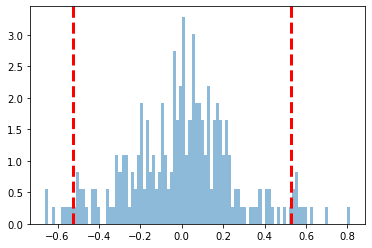

In [15]:
plt.hist(r,bins=100,density=True,alpha=0.5,histtype='stepfilled')
print('2*sigma = ',round(2*r.std(),4))
plt.axvline(x=round(2*r.std(),4), color='r', linestyle='--', linewidth=3)
plt.axvline(x=-round(2*r.std(),4), color='r', linestyle='--', linewidth=3)

위 히스토그램이 정규분포를 보이는지 판별하는 코드

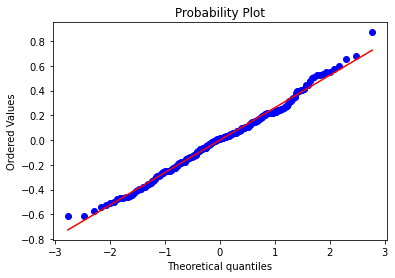

Normal Distribution


In [16]:
mdl = sm.ols(formula='Ar~Br', data=result)
resid=mdl.fit().resid
plt.figure()
probplot(resid, plot=plt)
plt.show()
k = stats.shapiro(resid)
if k[1] < 0.05:
    print('Not Normal Distribution')
else:
    print("Normal Distribution")

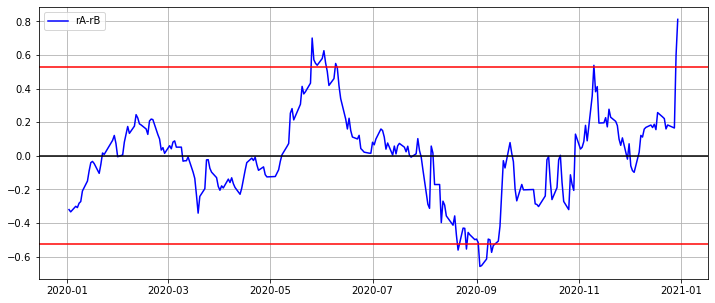

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(r, color='blue', label='rA-rB')
ax.grid(True)
ax.axhline(y=0, color='black', linestyle='-')
ax.axhline(y=P, color='red', linestyle='-') 
ax.axhline(y=-P, color='red', linestyle='-') 
plt.legend(loc=2)
plt.show()

In [18]:
result1 = pd.concat([chart,result],axis=1)

In [19]:
sm = result1.mean()['spread']
result['residual'] = result['spread']-sm
result

,Ar,Br,spread,residual
Date,,,,
2020-01-02,-1.536354,-1.216101,-0.320254,-0.320254
2020-01-03,-1.566950,-1.233196,-0.333753,-0.333753
2020-01-06,-1.556751,-1.255991,-0.300760,-0.300760
2020-01-07,-1.541453,-1.233196,-0.308257,-0.308257
2020-01-08,-1.566950,-1.284484,-0.282466,-0.282466
...,...,...,...,...
2020-12-23,1.747562,1.587613,0.159949,0.159949
2020-12-24,1.839348,1.655996,0.183352,0.183352
2020-12-28,1.798554,1.633202,0.165353,0.165353


In [20]:
r1 = pd.DataFrame(result['residual'][0:-2])
r2 = pd.DataFrame(result['residual'][1:-1])

In [21]:
def to_npc(data1,data2):
    a = data1.to_numpy()
    A = pd.DataFrame(a)
    b= data2.to_numpy()
    B = pd.DataFrame(b)
    c = pd.concat([A,B],axis=1)
    corra = c.corr()
    return corra.iloc[0,1]


In [23]:
rd = pd.DataFrame(r)

CC 추정하기

In [24]:
cov = np.cov(result['Ar'],result['Br'])
var = np.var(result['Br'])
CC = cov[1][0]/var
print(CC)

0.9692729785319536


이하는 중간발표때 사용한 백테스팅 과정

+2시그마 선에서 진입할 때

In [25]:
rd[rd[0]>P]

,0
Date,
2020-05-26,0.700851
2020-05-27,0.571710
2020-05-28,0.550409
2020-05-29,0.539012
2020-06-01,0.579059
2020-06-02,0.625552
2020-06-03,0.553416
2020-06-09,0.549534
2020-11-10,0.538435


In [26]:
a = -0.005<rd[0]
b = 0.005>rd[0]
rd[a&b]

,0
Date,
2020-02-03,0.004918
2020-07-13,0.004128
2020-07-23,0.002920
2020-10-14,-0.003626
2020-10-21,0.002967


In [27]:
dates = pd.date_range('6/9/2020', '7/13/2020')

In [28]:
dfa = pd.DataFrame(chart, index=dates, columns=['A'])
Qs = 100
Q = dfa.loc['6/9/2020']*Qs

In [29]:
dfb = pd.DataFrame(chart, index=dates, columns=['B'])
W = Q*CC
Ws = round(W/int(dfb.loc['6/9/2020']),0)

In [30]:
ac=int(+dfa.loc['6/9/2020']-dfa.loc['7/13/2020'])*Qs
bc=int(-dfb.loc['6/9/2020']+dfb.loc['7/13/2020'])*Ws
print('수익률: ',(ac+bc)/Q)


수익률:  A    0.229387
Name: 2020-06-09 00:00:00, dtype: float64


In [31]:
#1. 차분 데이터에서 매매 시기 찾아서 차분 데이터에 적용

In [32]:
# 10/13 사서 11/13 매도하는 전략
dates = pd.date_range('10/13/2020', '11/13/2020')
dfa = pd.DataFrame(chart, index=dates, columns=['A'])
Qs = 100
Q = dfa.loc['10/13/2020']*Qs
dfb = pd.DataFrame(chart, index=dates, columns=['B'])
W = Q*CC
Ws = round(W/int(dfb.loc['10/13/2020']),0)
ac=int(+dfa.loc['10/13/2020']-dfa.loc['11/13/2020'])*Qs
bc=int(-dfb.loc['10/13/2020']+dfb.loc['11/13/2020'])*Ws
print('수익률: ',(ac+bc)/Q)

수익률:  A   -0.03284
Name: 2020-10-13 00:00:00, dtype: float64


In [81]:
#2. 차분 데이터에서 매매 시기 찾아서 기본 데이터에 적용

In [33]:
#9/17 매수 , 10/14 매도
dates = pd.date_range('9/17/2020', '10/14/2020')
dfa = pd.DataFrame(chart, index=dates, columns=['A'])
Qs = 100
Q = dfa.loc['9/17/2020']*Qs
dfb = pd.DataFrame(chart, index=dates, columns=['B'])
W = Q*CC
Ws = round(W/int(dfb.loc['9/17/2020']),0)
ac=int(+dfa.loc['9/17/2020']-dfa.loc['10/14/2020'])*Qs
bc=int(-dfb.loc['9/17/2020']+dfb.loc['10/14/2020'])*Ws
print('수익률: ',(ac+bc)/Q)

수익률:  A   -0.009854
Name: 2020-09-17 00:00:00, dtype: float64
